# TGCN model - static approach - Stock Market

## Import libraries

In [7]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tools.SP100Stock import SP100Stocks
from models import TGCN, train

## Preprocessing

In [8]:
def future_close_price_to_buy_sell_class(sample: Data, threshold: float = 0.01):
	"""
	Transforms the target y to a three-class classification:
	- Down (0): return < -threshold
	- Neutral (1): -threshold <= return <= threshold
	- Up (2): return > threshold
	:param sample: Data sample
	:param threshold: Threshold for categorizing returns (default: 0.01 = 1%)
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	
	# Create three-class labels: 0=Down, 1=Neutral, 2=Up
	sample.y = torch.zeros_like(sample.returns, dtype=torch.long).squeeze(1)
	sample.y[sample.returns.squeeze(1) < -threshold] = 0  # Down
	sample.y[(sample.returns.squeeze(1) >= -threshold) & (sample.returns.squeeze(1) <= threshold)] = 1  # Neutral
	sample.y[sample.returns.squeeze(1) > threshold] = 2  # Up
	
	return sample

In [9]:
from functools import partial

weeks_ahead = 1
threshold = 0.0055  # 1% threshold for neutral zone

# Create a partial function with the threshold parameter
transform_with_threshold = partial(future_close_price_to_buy_sell_class, threshold=threshold)

dataset_pearson = SP100Stocks(root="../data/", adj_file_name='pearson_adj.npy', future_window=weeks_ahead, force_reload=True, transform=transform_with_threshold)
dataset_pearson, dataset_pearson[0]

dataset_hybrid = SP100Stocks(root="../data/", adj_file_name='hybrid_adj.npy', future_window=weeks_ahead, force_reload=True, transform=transform_with_threshold)
dataset_hybrid, dataset_hybrid[0]

Processing...


Loading and processing data for PyG format...
Values DataFrame shape: (70588, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 1078
Unique symbols count: 100
Unique dates count: 706

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']
Pivoted shape (Date x Symbol): (706, 100)

Final array shapes:
  x (features): (100, 706, 13)
  close_prices: (100, 706)
  Expected x shape: (nodes_nb=100, timestamps_nb=706, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 706])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=706)

Building edge index and edge weights...
  Created 1078 edges



Done!
Processing...


Loading and processing data for PyG format...
Values DataFrame shape: (70588, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 100
Adjacency matrix shape: (100, 100)
Number of nodes (from adj): 100
Number of edges: 720
Unique symbols count: 100
Unique dates count: 706

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']
Pivoted shape (Date x Symbol): (706, 100)

Final array shapes:
  x (features): (100, 706, 13)
  close_prices: (100, 706)
  Expected x shape: (nodes_nb=100, timestamps_nb=706, features_nb=13)
  After transpose: x shape = torch.Size([100, 13, 706])
  Expected: (nodes_nb=100, features_nb=13, timestamps_nb=706)

Building edge index and edge weights...
  Created 720 edges



Done!


(SP100Stocks(680),
 Data(x=[100, 13, 25], edge_index=[2, 720], y=[100], edge_weight=[720], close_price=[100, 25], close_price_y=[100, 1], returns=[100, 1], market_return=0.017313802614808083))

In [10]:
train_part = .9
batch_size = 32

train_dataset_pearson, test_dataset_pearson = dataset_pearson[:int(train_part * len(dataset_pearson))], dataset_pearson[int(train_part * len(dataset_pearson)):]
print(f"Train dataset_pearson: {len(train_dataset_pearson)}, Test dataset_pearson: {len(test_dataset_pearson)}")
train_dataloader_pearson, test_dataloader_pearson = DataLoader(train_dataset_pearson, batch_size=batch_size, shuffle=True), DataLoader(test_dataset_pearson, batch_size=len(test_dataset_pearson), shuffle=True)

Train dataset_pearson: 612, Test dataset_pearson: 68


In [11]:
train_part = .9
batch_size = 32

train_dataset_hybrid, test_dataset_hybrid = dataset_hybrid[:int(train_part * len(dataset_hybrid))], dataset_hybrid[int(train_part * len(dataset_hybrid)):]
print(f"Train dataset_hybrid: {len(train_dataset_hybrid)}, Test dataset_hybrid: {len(test_dataset_hybrid)}")
train_dataloader_hybrid, test_dataloader_hybrid = DataLoader(train_dataset_hybrid, batch_size=batch_size, shuffle=True), DataLoader(test_dataset_hybrid, batch_size=len(test_dataset_hybrid), shuffle=True)

Train dataset_hybrid: 612, Test dataset_hybrid: 68


## Model set up

### Pearson graph approach

In [12]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset_pearson[0].x.shape[-2], 3, 16, 2, .3  # 3 classes: Down, Neutral, Up
model = TGCN(in_channels, out_channels, hidden_size, layers_nb,use_gat=True)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100
	
# Use CrossEntropyLoss for multi-class classification (3 classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(13, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=45, out_features=16, bias=True)
      (lin_r): Linear(in_features=45, out_features=16, bias=True)
      (lin_c): Linear(in_features=45, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
    (1): Identity()
  )
)

In [13]:

# Set device to CUDA
device = torch.device('cuda')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)

Using device: cuda


#### Training

In [14]:
train(model, optimizer, criterion, train_dataloader_pearson, test_dataloader_pearson, num_epochs, "UpDownTrend_pearson_threshold", measure_acc=True)

Epochs: 100%|██████████| 100/100 [21:53<00:00, 13.14s/it, Batch=100.0%]


([1.1005301237106324,
  1.0968998789787292,
  1.0981608033180237,
  1.0972081899642945,
  1.0974755585193634,
  1.094621616601944,
  1.096550965309143,
  1.093870961666107,
  1.0949398458003998,
  1.0935468256473542,
  1.0939810395240783,
  1.0918375074863433,
  1.0953940093517303,
  1.0934613406658173,
  1.0916626095771789,
  1.0932098567485808,
  1.091499572992325,
  1.0913247287273407,
  1.093445485830307,
  1.0907691061496734,
  1.0907623052597046,
  1.091192650794983,
  1.0897984564304353,
  1.090145754814148,
  1.0900377988815309,
  1.0901334464550019,
  1.0899539828300475,
  1.0885066270828248,
  1.0891833841800689,
  1.088344192504883,
  1.0879522264003754,
  1.0883545696735382,
  1.0898232758045197,
  1.0864107191562653,
  1.086292177438736,
  1.085232436656952,
  1.085049217939377,
  1.083924227952957,
  1.0828855156898498,
  1.0841922879219055,
  1.0793489933013916,
  1.0835285663604737,
  1.0788162410259248,
  1.0803212583065034,
  1.0819457232952119,
  1.0787296772003174,


In [15]:
from datetime import datetime

# Generate timestamp for model filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"../runs/tgcn_pearson_{model.__class__.__name__}_{timestamp}.pt"

# Save model
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../runs/tgcn_pearson_TGCN_20260123_191258.pt


#### Visualization

Plot saved to: ../runs/tgcn_pearson_TGCN_20260123_191258_predictions.png


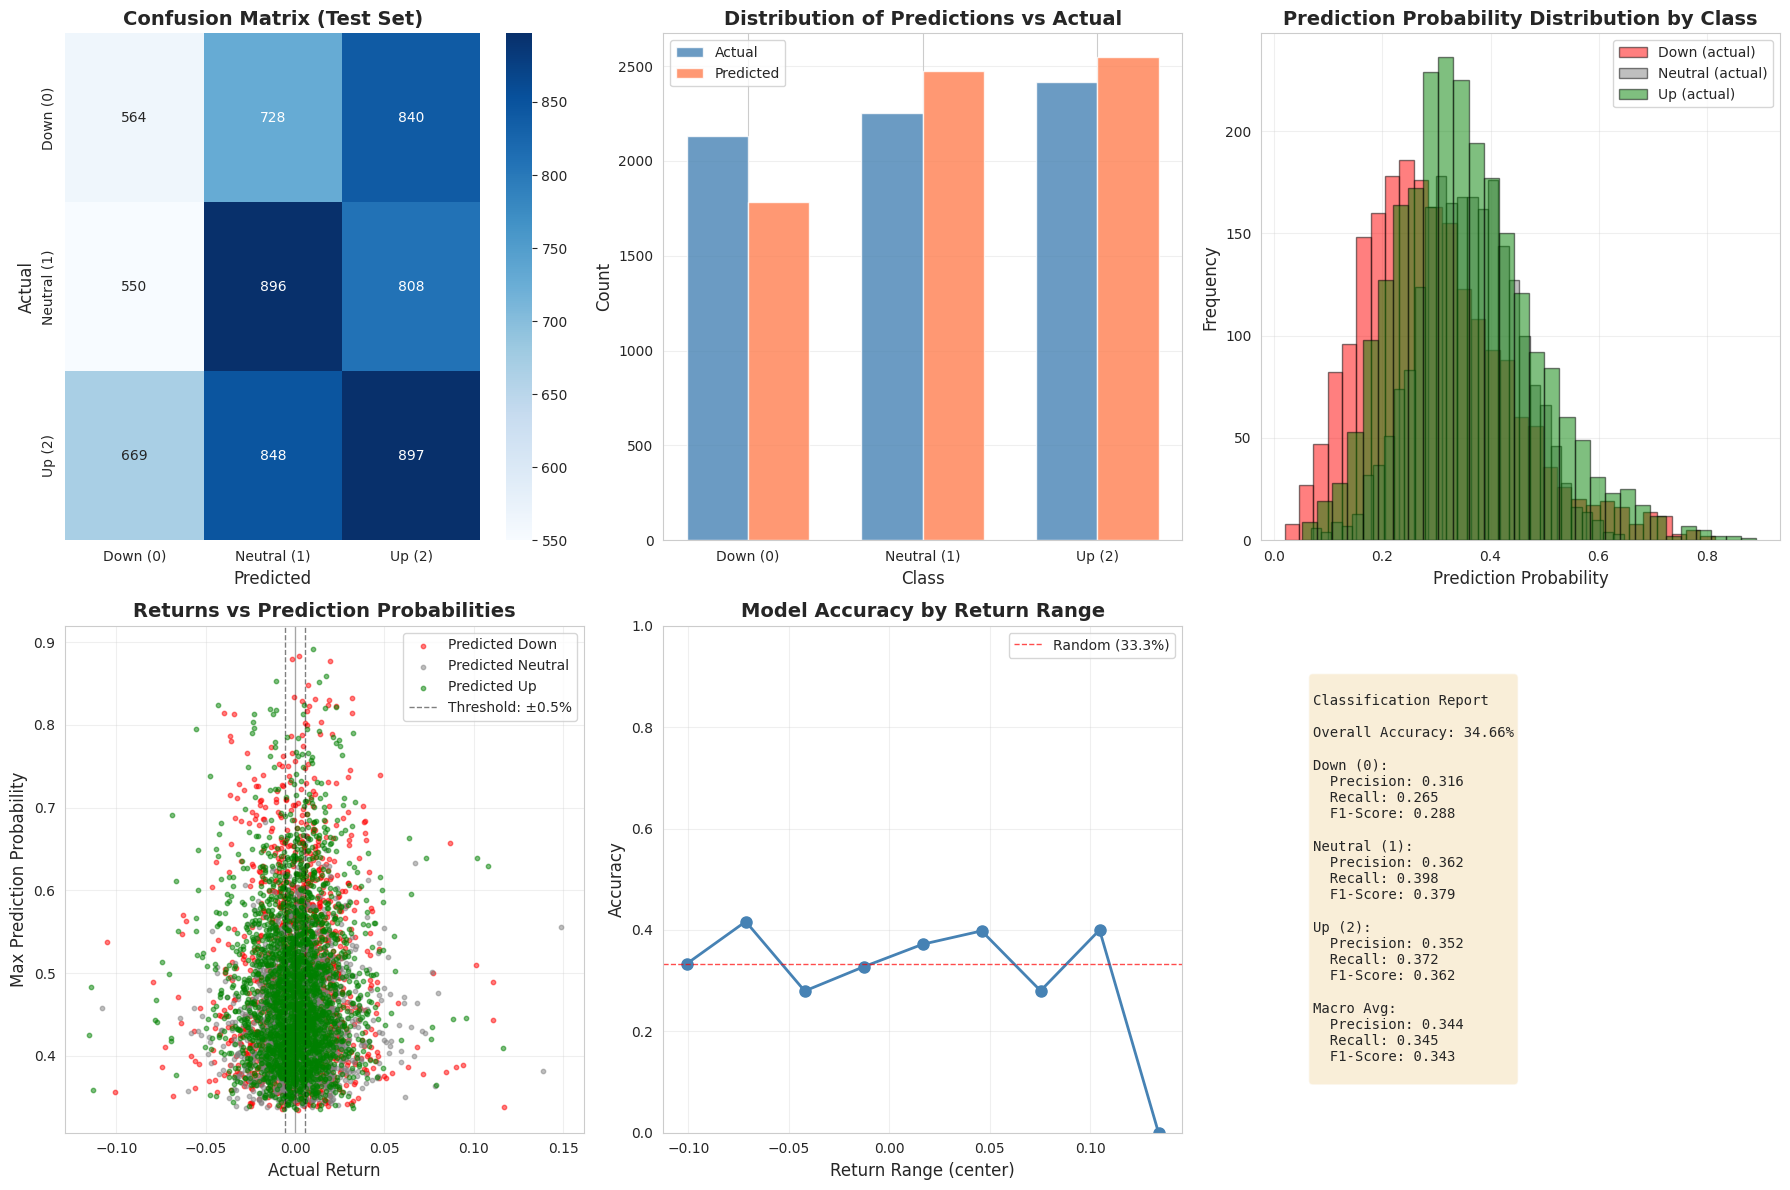


PREDICTION VISUALIZATION SUMMARY
Total predictions: 6800
Overall accuracy: 34.66%

Class Distribution (Actual):
  Down (0):    2132 (31.35%)
  Neutral (1):  2254 (33.15%)
  Up (2):      2414 (35.50%)

Class Distribution (Predicted):
  Down (0):    1783 (26.22%)
  Neutral (1):  2472 (36.35%)
  Up (2):      2545 (37.43%)

Average max prediction probability: 0.466
Average actual return: 0.0009 (0.09%)
Threshold used: ±0.55%



In [16]:
from visualization import plot_model_predictions

# Visualize model predictions on test set and save the plot
plot_model_predictions(model, test_dataloader_pearson, device, threshold, save_path=model_path)